최적의 모델을 위한 Cost 함수: 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어

비용 함수 목표 = Min(RSS(W) + alpha * ||W||22)
alpha?
- 값을 크게 하면 비용 함수는 회귀 계수 W 값을 작게 해 과적합 개선
- 값을 작게 하면 학습 데이터 적합을 더 개선
규제(Regularization): alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합 개선
- L2 규제: W의 제곱에 대해 패널티 부여
- L1 규제: W의 절대값에 대해 패널티 부여

## 릿지 회귀

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost
from scipy import stats
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# data set load
boston = load_boston()

bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF["PRICE"] = boston.target
print("Boston Dataset Size: {0}".format(bostonDF.shape))
bostonDF.head()

Boston Dataset Size: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis=1, inplace=False)

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# set alpha to 10
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("Negative MSE scores:", np.round(neg_mse_scores, 3))
print("RMSE scores:", np.round(rmse_scores, 3))
print("mean RMSE:", avg_rmse)

Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
mean RMSE: 5.518166280868973


In [8]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha = alpha)

     # cross_val_score
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    ave_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print("alpha {0}, 5 folds average RMSE: {1:.3f}".format(alpha, ave_rmse))

alpha 0, 5 folds average RMSE: 5.829
alpha 0.1, 5 folds average RMSE: 5.788
alpha 1, 5 folds average RMSE: 5.653
alpha 10, 5 folds average RMSE: 5.518
alpha 100, 5 folds average RMSE: 5.330


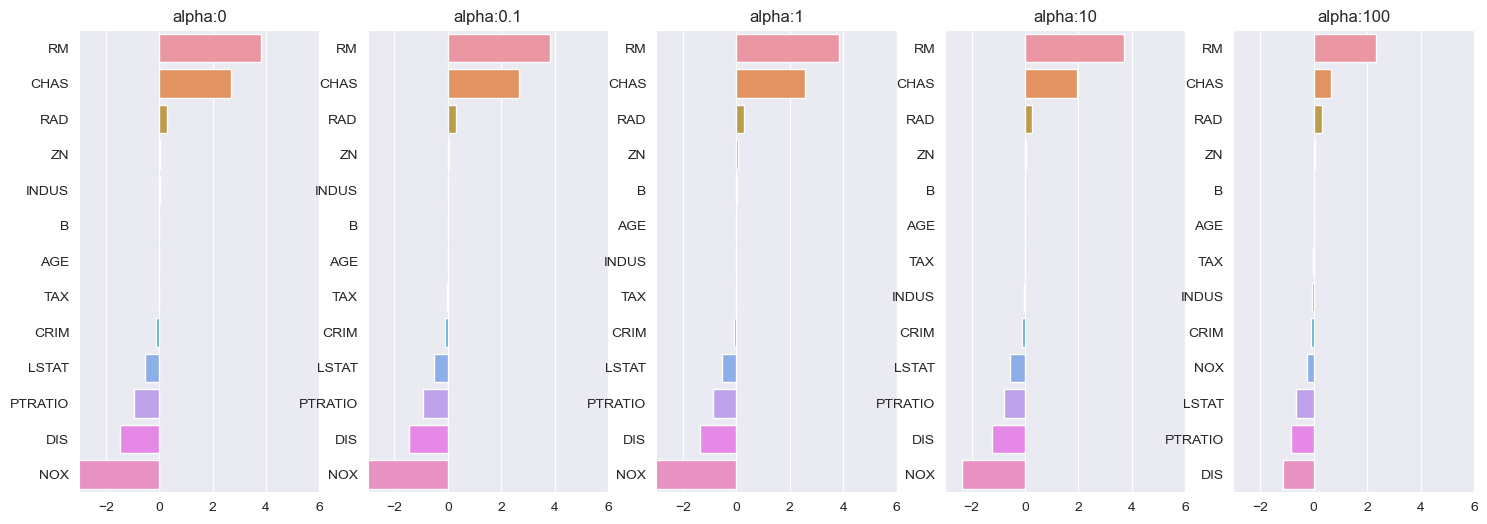

In [9]:
# f9r visualization
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    # convert to Series, add to DataFrame
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = "alpha:" + str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

In [10]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = "alpha:" + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


## Lasso Regression

Scikit Learn: using Lasso class to express Lasso Regression

In [14]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose: print("###", model_name, "###")
    for param in params:
        if model_name == "Ridge": model = Ridge(alpha=param)
        elif model_name == "Lasso": model = Lasso(alpha=param)
        elif model_name == "ElasticNet": model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                         scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print("alpha {0}, 5 folds average RMSE: {1:.3f}".format(param, avg_rmse))
        # cross_val_score only returns evaluation metric, so refit
        model.fit(X_data_n, y_target_n)

        if return_coeff:
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = "alpha:" + str(param)
            coeff_df[colname] = coeff
    return coeff_df

In [15]:
# set alpha parameters form Lasso and get_linear_reg_eval()
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval("Lasso", params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

### Lasso ###
alpha 0.07, 5 folds average RMSE: 5.612
alpha 0.1, 5 folds average RMSE: 5.615
alpha 0.5, 5 folds average RMSE: 5.669
alpha 1, 5 folds average RMSE: 5.776
alpha 3, 5 folds average RMSE: 6.189


## Elastic Net Regression

min(RSS(W) + alpha2 * ||W||22 + alpha1 * ||W||1)

In [16]:
# l1_ratio = 0.7
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval("ElasticNet", params=elastic_alphas,
                                       X_data_n=X_data, y_target_n=y_target)

### ElasticNet ###
alpha 0.07, 5 folds average RMSE: 5.542
alpha 0.1, 5 folds average RMSE: 5.526
alpha 0.5, 5 folds average RMSE: 5.467
alpha 1, 5 folds average RMSE: 5.597
alpha 3, 5 folds average RMSE: 6.068


In [18]:
sort_column = "alpha:" + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


## 데이터 변환
선형 모델은 선형 관계가 있다는 가정 하에 예측 수행
타깃 값의 분포도가 심하게 왜곡된 경우 데이터 스케일링/정규화 작업 수행

- StandardScaler로 변환, MinMaxScaler 정규화
- 스케일링/정규화 이후 다항 특성 적용하여 반환
- log 함수 적용 (가장 많이 사용)

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures


def get_scaled_data(method="None", p_degree=None, input_data=None):
    scaled_data = input_data
    if method == "Standard":
        scaled_data = StandardScaler().fit_transform(input_data)
    if method == "MinMax":
        scaled_data = MinMaxScaler().fit_transform(input_data)
    if method == "Log":
        scaled_data = np.log1p(input_data)

    if p_degree is not None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [21]:
# Ridge alpha values
alphas = [0.1, 1, 10, 100]

scale_methods = [(None, None), ("Standard", None), ("Standard", 2),
                 ("MinMax", None), ("MinMax", 2), ("Log", None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print("\n ## type: {0}, Polynomial Degree: {1}".format(scale_method[0], scale_method[1]))
    get_linear_reg_eval("Ridge", params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)


 ## type: None, Polynomial Degree: None
alpha 0.1, 5 folds average RMSE: 5.788
alpha 1, 5 folds average RMSE: 5.653
alpha 10, 5 folds average RMSE: 5.518
alpha 100, 5 folds average RMSE: 5.330

 ## type: Standard, Polynomial Degree: None
alpha 0.1, 5 folds average RMSE: 5.826
alpha 1, 5 folds average RMSE: 5.803
alpha 10, 5 folds average RMSE: 5.637
alpha 100, 5 folds average RMSE: 5.421

 ## type: Standard, Polynomial Degree: 2
alpha 0.1, 5 folds average RMSE: 8.827
alpha 1, 5 folds average RMSE: 6.871
alpha 10, 5 folds average RMSE: 5.485
alpha 100, 5 folds average RMSE: 4.634

 ## type: MinMax, Polynomial Degree: None
alpha 0.1, 5 folds average RMSE: 5.764
alpha 1, 5 folds average RMSE: 5.465
alpha 10, 5 folds average RMSE: 5.754
alpha 100, 5 folds average RMSE: 7.635

 ## type: MinMax, Polynomial Degree: 2
alpha 0.1, 5 folds average RMSE: 5.298
alpha 1, 5 folds average RMSE: 4.323
alpha 10, 5 folds average RMSE: 5.185
alpha 100, 5 folds average RMSE: 6.538

 ## type: Log, Polynomi